In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, Nadam, RMSprop
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

C:\Users\BCI034\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\BCI034\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\BCI034\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\BCI034\Anaconda3\envs\tensorflow\lib\site-pack

In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"McDermott, Miss. Brigdet Delia",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]

In [8]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


In [9]:
for dataset in combine:    
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [10]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [11]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test = test.drop(['Name'], axis=1)
combine = [train, test]

In [12]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [13]:
guess_ages = numpy.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [14]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [15]:
freq_port = train.Embarked.dropna().mode()[0]
freq_port
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    


In [16]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)



In [17]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [53]:
model = keras.Sequential([
        layers.Dense(10, activation=tf.nn.relu, input_shape=[10]),
        
       # layers.Dense(1 , activation="sigmoid")
        # layers.Dense(32, activation=tf.nn.relu),
       # 
         layers.Dense(5,  activation=tf.nn.relu),
#
         layers.Dense(1,  activation="sigmoid")
    ])
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy', 'mean_squared_error'])

In [19]:
 train_labels = train.pop('Survived')

In [125]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=250)
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=111)
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

    

In [124]:
 def valmodel(datan, ucrop, uPPM):
    cvscores = []
    ttest_predictions =[]
    ttest_labels = []

    tame = 0
    same = 0
    plott = pd.DataFrame()
    for train, test in kfold.split(datan):
       
        train_dataset = datan.iloc[train]
        test_dataset = datan.iloc[test]

        
        
        train_labels = train_dataset.pop('Survived')
        train_stats = train_dataset.describe()
    
        train_stats = train_stats.transpose()
    
        test_labels = test_dataset.pop('Survived')
       # normed_train_data = norm(train_dataset, train_stats )
       # normed_test_data = norm(test_dataset, train_stats)
       
        model = build_model(len(train_dataset.keys()))
        history = model.fit(train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
    
        plot_history(history)
        loss, mae, mse = model.evaluate(test_data, test_labels, verbose=0)
        test_predictions = model.predict(test_data).flatten()
        tame = tame + mae
        same = same + mse
       
        ttest_labels = ttest_labels + (test_labels.values.tolist())
        ttest_predictions = ttest_predictions + (test_predictions.tolist())

        
    plott['label'] = ttest_labels

   
    plott['pre'] = ttest_predictions
    plott['resid'] = -(plott['label'] - plott['pre'])

    plott['MAE'] = tame / 10
    plott['MSE']= same / 10
   
    
    return plott

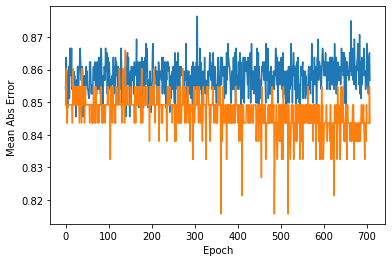

In [111]:
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_acc'],
          label = 'Val Error')

In [112]:
 loss, mae, mse = model.evaluate(train, train_labels, verbose=0)

In [113]:
mae

0.86419755

In [114]:
train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,3,0,1,1,0,0,0,1,2,0
1,1,1,2,1,0,3,1,3,2,0
2,3,1,1,0,0,1,0,2,1,1
3,1,1,2,1,0,3,0,3,2,0
4,3,0,2,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
886,2,0,1,0,0,1,0,5,1,1
887,1,1,1,0,0,2,0,2,1,1
888,3,1,1,1,2,2,0,2,4,0
889,1,0,1,0,0,2,1,1,1,1


In [115]:
 test_labels = test.pop('PassengerId')

KeyError: 'PassengerId'

In [116]:
test_predictions = model.predict(test).flatten()

In [117]:
result2 = pd.DataFrame()

In [118]:
result2["PassengerId"] = test_labels

In [119]:
result2

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [120]:
result2["Survived"] =test_predictions

In [121]:
result2.loc[result2["Survived"] >= .5, "Survived"] = 1 
result2.loc[result2["Survived"] < .5, "Survived"] = 0 

In [122]:
result2.Survived = result2.Survived.astype(int)

In [123]:
result2.to_csv(r'C:\\Users\\BCI034\\Desktop\\result.csv',index=False)